# **Deep learning for image analysis with Python**

#### Fernando Cervantes, Systems Analyst I, Imaging Solutions, Research IT
#### fernando.cervantes@jax.org    (slack) @fernando.cervantes

## 5 Implement the training loop

### 5.1 _Data preparation_

Using the *torchvision* library, pull the CIFAR 100 dataset.<br>
We'll need to transform images from this dataset from PIL Images to PyTorch tensors.

In [152]:
from torchvision.datasets import CIFAR100

In [2]:
from torchvision.transforms import ToTensor, Normalize, Compose

In [3]:
cifar_transform_list = [
    ToTensor(),
]

cifar_transform = Compose(cifar_transform_list)

In [4]:
cifar_trn_dataset = CIFAR100(root='/home/cervaf/data', download=False, train=True, transform=cifar_transform)

In [5]:
cifar_trn_dataset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /home/cervaf/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
import matplotlib.pyplot as plt

Plot some of the CIFAR labeled examples. Check [here](https://huggingface.co/datasets/cifar100) the labels

torch.Size([3, 32, 32])


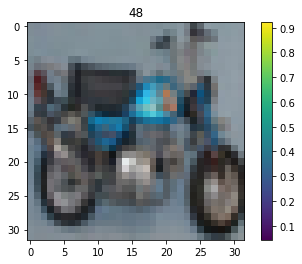

In [7]:
x, t = cifar_trn_dataset[10000]
print(x.size())
plt.imshow(x.permute(1, 2, 0))
plt.title(t)
plt.colorbar()
plt.show()

***
### 5.2 _Network preparation_

Implement a Residual Network ([ResNet](https://arxiv.org/pdf/1512.03385.pdf))<br>
The torchvision module from pytorch provides models that have been pre-trained with the ImageNet dataset (1.2 million images natural images for training, with 1000 different classes)<br>
This is usefull for *transfer the learning* to other applications, or use those as *warmed-up* models, instead of random initialization of the weights.<br>
However, the architecture is fixed to work with input images of $224\times224$ pixels with $3$ channels (RBG), and output $1000$ classes.<br>
For our example with the CIFAR 100 dataset, that is composed by images of $32\times32$ pixesl in RGB, and only has $100$ classes, thre pre-trained models won't be usefull.


In [8]:
import torchvision.models as models

In [9]:
print(models.resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
import torch
import torch.nn as nn

Lets implement the residual block of the ResNet as a custom pytorch Module

In [11]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResNetBlock, self).__init__()
        
        if downsample:
            self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, bias=False)
            self.downsample = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=2, padding=0, bias=False)
        else:
            self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.downsample = nn.Identity()
        
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        
        self.conv_2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)        
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        identity = self.downsample(x)
        
        fx = self.relu(self.conv_1(x))
        fx = self.bn1(fx)
        
        fx = self.conv_2(fx)
        fx = self.bn2(fx)

        fx = self.relu(fx + identity)
        
        return fx

In [72]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet, self).__init__()
        
        # Input 32x32x3
        
        self.embedding = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(num_features=64) 
        self.relu = nn.ReLU()
        # Output is 32x32x64
        
        self.block_1_1 = ResNetBlock(in_channels=64, out_channels=64, downsample=True)
        # Output is 16x16x64
        self.block_1_2 = ResNetBlock(in_channels=64, out_channels=64, downsample=False)
        # Output is 16x16x64
        
        self.block_2_1 = ResNetBlock(in_channels=64, out_channels=128, downsample=True)
        # Output is 8x8x128
        self.block_2_2 = ResNetBlock(in_channels=128, out_channels=128, downsample=False)
        # Output is 8x8x128
            
        self.block_3_1 = ResNetBlock(in_channels=128, out_channels=256, downsample=True)
        # Output is 4x4x256
        self.block_3_2 = ResNetBlock(in_channels=256, out_channels=256, downsample=False)
        # Output is 4x4x256
        
        self.block_4_1 = ResNetBlock(in_channels=256, out_channels=512, downsample=True)
        # Output is 2x2x512
        self.block_4_2 = ResNetBlock(in_channels=512, out_channels=512, downsample=False)
        # Output is 2x2x512
        
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        # Output is 1x1x512
        
        self.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
        # output is 1xnum_classes
        
    def forward(self, x):
        fx = self.bn(self.relu(self.embedding(x)))
        
        fx = self.block_1_1(fx)
        fx = self.block_1_2(fx)
        
        fx = self.block_2_1(fx)
        fx = self.block_2_2(fx)
        
        fx = self.block_3_1(fx)
        fx = self.block_3_2(fx)
        
        fx = self.block_4_1(fx)
        fx = self.block_4_2(fx)
        
        fx = self.avg_pool(fx)
        
        logits = self.fc(fx.view(-1, 512))
        
        return logits

Alternatively, we can define the layers of our network using the Sequential function to reduce the code in the forward pass

In [73]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet, self).__init__()
        
        self.embedding = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(num_features=64) 
        self.relu = nn.ReLU()
        # Output is 32x32x64
        
        self.layer_1 = nn.Sequential(
            ResNetBlock(in_channels=64, out_channels=64, downsample=True),
            ResNetBlock(in_channels=64, out_channels=64, downsample=False)
        )
        # Output is 16x16x64
        
        self.layer_2 = nn.Sequential(
            ResNetBlock(in_channels=64, out_channels=128, downsample=True),
            ResNetBlock(in_channels=128, out_channels=128, downsample=False)
        )
        # Output is 8x8x128
            
        self.layer_3 = nn.Sequential(
            ResNetBlock(in_channels=128, out_channels=256, downsample=True),
            ResNetBlock(in_channels=256, out_channels=256, downsample=False)
        )
        # Output is 4x4x256
        
        self.layer_4 = nn.Sequential(
            ResNetBlock(in_channels=256, out_channels=512, downsample=True),
            ResNetBlock(in_channels=512, out_channels=512, downsample=False)
        )
        # Output is 2x2x512
        
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        # Output is 1x1x512
        
        self.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
        # output is 1xnum_classes
        
    def forward(self, x):
        fx = self.bn(self.relu(self.embedding(x)))
        
        fx = self.layer_1(fx)
        
        fx = self.layer_2(fx)
        
        fx = self.layer_3(fx)
        
        fx = self.layer_4(fx)
        
        fx = self.avg_pool(fx)
        
        logits = self.fc(fx.view(-1, 512))
        
        return logits        

Or even have all layers as a single operation

In [74]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet, self).__init__()
        
        self.embedding = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)        
        self.bn = nn.BatchNorm2d(num_features=64) 
        self.relu = nn.ReLU()
        # Output is 32x32x64
        
        self.layers = nn.Sequential(
            ResNetBlock(in_channels=64, out_channels=64, downsample=True),
            ResNetBlock(in_channels=64, out_channels=64, downsample=False),
            ResNetBlock(in_channels=64, out_channels=128, downsample=True),
            ResNetBlock(in_channels=128, out_channels=128, downsample=False),
            ResNetBlock(in_channels=128, out_channels=256, downsample=True),
            ResNetBlock(in_channels=256, out_channels=256, downsample=False),
            ResNetBlock(in_channels=256, out_channels=512, downsample=True),
            ResNetBlock(in_channels=512, out_channels=512, downsample=False)
        )
        # Output is 2x2x512
        
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        # Output is 1x1x512
        
        self.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
        # output is 1xnum_classes
        
    def forward(self, x):
        fx = self.bn(self.relu(self.embedding(x)))
        
        fx = self.layers(fx)
        
        fx = self.avg_pool(fx)
        
        logits = self.fc(fx.view(-1, 512))
        
        return logits        

In [75]:
net = ResNet(in_channels=3, num_classes=100)
print(net)

ResNet(
  (embedding): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layers): Sequential(
    (0): ResNetBlock(
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ResNetBlock(
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (downsample): Identity()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(64,

***
Test our ResNet implementation

In [76]:
x, t = cifar_trn_dataset[1]
print(x.size())

torch.Size([3, 32, 32])


In [77]:
# This will fail because the size of x is not what is expected by net
y = net(x)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [3, 32, 32] instead

In [79]:
# But after viewing x as a batch with a single example, we can fed it to the network
y = net(x.view(1, 3, 32, 32))

print(y.size())
print(y.sum(dim=1))
print(y)

torch.Size([1, 100])
tensor([1.1885], grad_fn=<SumBackward1>)
tensor([[ 0.7682, -0.9198, -0.4656, -0.3155, -0.0148,  0.2102,  0.0134,  0.1363,
         -0.1538, -0.2796,  0.3549, -0.4964,  0.1597,  0.4472, -0.6782, -0.6241,
         -0.6091,  0.5730, -0.2939,  0.2387, -0.2310, -0.5138, -0.7074, -0.5439,
         -0.9275, -0.2792,  0.5270, -0.0719,  0.8597, -0.8239, -0.2392,  0.6188,
          0.0203,  0.3874,  0.1777,  0.2709,  0.3435,  0.0477,  0.5461, -1.4005,
         -0.5754,  0.0962, -0.1667,  1.0541,  0.0373, -0.3617,  0.1829, -0.6936,
          0.7303,  0.5240, -0.6582,  1.0047,  0.1160, -0.0509, -0.4605,  0.0807,
          0.3868,  0.0814,  0.2990, -0.2222,  0.3234,  0.7954,  0.2371, -1.0289,
         -0.3986,  0.5613,  0.3617,  0.8207,  0.3197,  0.8696,  0.2645, -0.2022,
         -0.3575, -0.3321, -0.4513,  0.1940,  0.3550, -0.2696,  0.6424, -0.1760,
         -0.2067,  0.0916, -1.3552,  0.5074,  0.9258,  0.1812, -0.8788, -0.1726,
          0.6985,  0.0292, -0.2175, -0.3770,  1

***
### 5.3 _Definition of the optimization problem_

Define the loss function.<br>
For this classification problem we can use the CrossEntropyLoss function from PyTorch.<br>
The default behavior of calling this function is to compute the cross-entropy loss between the probability predicted by our network, and the index of the real class.

In [80]:
criterion = nn.CrossEntropyLoss()

In [81]:
# Convert the target t to a tensor, because it is a single integer
loss = criterion(y, torch.tensor([t]))
loss

tensor(5.5880, grad_fn=<NllLossBackward0>)

***
Define our optimizer.

In [82]:
import torch.optim as optim

In [83]:
optimizer = optim.Adam(
    params=net.parameters(),
    lr=1e-4
)

Test our optimizer

In [84]:
optimizer.zero_grad() # Clean the gradient accumulator

x, t = cifar_trn_dataset[1]

y = net(x.view(1, 3, 32, 32))
loss = criterion(y, torch.tensor([t]))

loss.backward()

optimizer.step() # In this command, the parameters of the network are updated

In [85]:
print('Loss before one step of optimization %.8f' % loss)

Loss before one step of optimization 5.58801746


In [86]:
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

In [87]:
starter.record()
x, t = cifar_trn_dataset[1]

optimizer.zero_grad() # Clean the gradient accumulator

y = net(x.view(1, 3, 32, 32))
loss = criterion(y, torch.tensor([t]))

loss.backward()

optimizer.step()
ender.record()
torch.cuda.synchronize()

In [88]:
print('Loss after one step of optimization %.8f (%.4f ms)' % (loss, starter.elapsed_time(ender)))

Loss after one step of optimization 5.11485863 (312.3460 ms)


***
### Setup for training in GPU

In [89]:
# Move our network to the GPU memory, as well as our criterion
net.cuda()
criterion.cuda()

# Define the optimizer after we have moved the network to the GPU, so the update is perfomred in GPU momory
optimizer = optim.Adam(
    params=net.parameters(),
    lr=1e-4
)

In [90]:
starter.record()
x, t = cifar_trn_dataset[1]

optimizer.zero_grad() # Clean the gradient accumulator

# Move the input to GPU memory before feeding the network with it
y = net(x.view(1, 3, 32, 32).cuda())

# Move the target as well to compute the loss on the GPU
loss = criterion(y, torch.tensor([t]).cuda())

loss.backward()

optimizer.step()

# this is necesary only when measuring the execution time
ender.record()
torch.cuda.synchronize()

In [91]:
print('Loss after one step of optimization %.16f (%.16f ms)' % (loss, starter.elapsed_time(ender)))

Loss after one step of optimization 4.5383162498474121 (151.3937225341796875 ms)


***
### 5.4 _Implement the training loop_

The DataLoader class in PyTorch is usefull to split the dataset into batches.<br>
It also convert the individual targets to tensors that can be used directly by the loss function

In [92]:
from torch.utils.data import DataLoader

Generate a data loader for our training data from MNIST

In [93]:
cifar_trn_loader = DataLoader(
    cifar_trn_dataset,
    batch_size=128,
    shuffle=True,
    pin_memory=True
)

In [94]:
print('Dataset size:', len(cifar_trn_dataset))
print('DataLoader size:', len(cifar_trn_loader))

Dataset size: 50000
DataLoader size: 391


#### Run one *epoch* of training

In [95]:
starter.record()
trn_loss = []
for i, (x, t) in enumerate(cifar_trn_loader):
    optimizer.zero_grad()
    
    x = x.cuda()
    t = t.cuda()
    
    y = net(x)
    
    loss = criterion(y, t)
    
    loss.backward()
    
    trn_loss.append(loss.item())
    
    optimizer.step()
    
    if i % 100 == 0:
        print('[%i] Loss %.8f' % (i, loss))
        
ender.record()
torch.cuda.synchronize()

[0] Loss 4.81175327
[100] Loss 3.89317751
[200] Loss 3.62282014
[300] Loss 3.34649014


In [96]:
starter.elapsed_time(ender) / 1000

25.8020234375

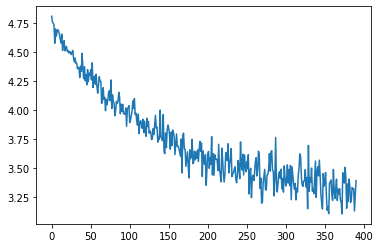

In [97]:
plt.plot(trn_loss)

#### Run several *epochs*

In [98]:
trn_loss = []
net.train()

starter.record()

for e  in range(10):
    avg_loss = 0
    for i, (x, t) in enumerate(cifar_trn_loader):
        optimizer.zero_grad()

        x = x.cuda()
        t = t.cuda()
        
        y = net(x)

        loss = criterion(y, t)

        loss.backward()
        
        avg_loss += loss.item()
        trn_loss.append(loss.item())

        optimizer.step()
    
    avg_loss = avg_loss / len(cifar_trn_loader)
    print('[Epoch %02i] %.8f' % (e, avg_loss))

ender.record()
torch.cuda.synchronize()

[Epoch 00] 2.93849048
[Epoch 01] 2.44811500
[Epoch 02] 2.02072319
[Epoch 03] 1.59845660
[Epoch 04] 1.14853404
[Epoch 05] 0.72458910
[Epoch 06] 0.41159044
[Epoch 07] 0.26905134
[Epoch 08] 0.19039435
[Epoch 09] 0.18367449


In [99]:
starter.elapsed_time(ender) / 1000

253.455125

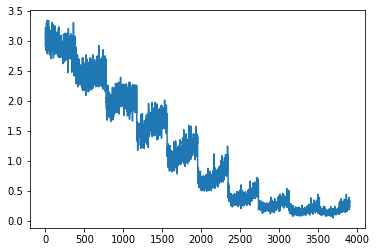

In [100]:
plt.plot(trn_loss)

#### Save the trained model (checkpoint)

In [104]:
torch.save(net.state_dict(), 'resnet_20220420.pth')

***
#### Test the trained model
Use the test partition of the CIFAR 100 dataset

In [105]:
cifar_tst_dataset = CIFAR100(root='/home/cervaf/data', download=False, train=False, transform=cifar_transform)
cifar_tst_loader = DataLoader(cifar_tst_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [106]:
import sklearn.metrics
import numpy as np

In [154]:
# Load the checkpoint
state_dict = torch.load('resnet_20220420.pth')

In [155]:
for k in state_dict.keys():
    print(k)

embedding.weight
bn.weight
bn.bias
bn.running_mean
bn.running_var
bn.num_batches_tracked
layers.0.conv_1.weight
layers.0.downsample.weight
layers.0.bn1.weight
layers.0.bn1.bias
layers.0.bn1.running_mean
layers.0.bn1.running_var
layers.0.bn1.num_batches_tracked
layers.0.conv_2.weight
layers.0.bn2.weight
layers.0.bn2.bias
layers.0.bn2.running_mean
layers.0.bn2.running_var
layers.0.bn2.num_batches_tracked
layers.1.conv_1.weight
layers.1.bn1.weight
layers.1.bn1.bias
layers.1.bn1.running_mean
layers.1.bn1.running_var
layers.1.bn1.num_batches_tracked
layers.1.conv_2.weight
layers.1.bn2.weight
layers.1.bn2.bias
layers.1.bn2.running_mean
layers.1.bn2.running_var
layers.1.bn2.num_batches_tracked
layers.2.conv_1.weight
layers.2.downsample.weight
layers.2.bn1.weight
layers.2.bn1.bias
layers.2.bn1.running_mean
layers.2.bn1.running_var
layers.2.bn1.num_batches_tracked
layers.2.conv_2.weight
layers.2.bn2.weight
layers.2.bn2.bias
layers.2.bn2.running_mean
layers.2.bn2.running_var
layers.2.bn2.num_bat

In [156]:
# Create a new network object
test_net = ResNet(in_channels=3, num_classes=100)

In [157]:
# Load the trained weights
test_net.load_state_dict(state_dict)

<All keys matched successfully>

#### Test the accuracy of the trained network

In [158]:
tst_avg_loss = 0
tst_avg_acc = 0
tst_avg_acc_5 = 0
tst_avg_acc_10 = 0

test_net.cuda()
test_net.eval()

for i, (x, t) in enumerate(cifar_tst_loader):
    with torch.no_grad():
        x = x.cuda()
        t = t.cuda()
        
        y = test_net(x)
        loss = criterion(y, t)
    
    tst_avg_loss += loss.item()

    tst_avg_acc += sklearn.metrics.accuracy_score(t.cpu().numpy(), y.cpu().argmax(dim=1).numpy(), normalize=False)
    tst_avg_acc_5 += sklearn.metrics.top_k_accuracy_score(t.cpu().numpy(), y.cpu().numpy(), k=5, labels=np.arange(100), normalize=False)
    tst_avg_acc_10 += sklearn.metrics.top_k_accuracy_score(t.cpu().numpy(), y.cpu().numpy(), k=10, labels=np.arange(100), normalize=False)

tst_avg_loss = tst_avg_loss / len(cifar_tst_loader)
tst_avg_acc = tst_avg_acc / len(cifar_tst_dataset) * 100
tst_avg_acc_5 = tst_avg_acc_5 / len(cifar_tst_dataset) * 100
tst_avg_acc_10 = tst_avg_acc_10 / len(cifar_tst_dataset) * 100
print('Average test loss %.8f, average accuracy %.2f %%, average accuracy@5 %.2f %%, average accuracy@10 %.2f %%' % (tst_avg_loss, tst_avg_acc, tst_avg_acc_5, tst_avg_acc_10))

Average test loss 4.78111167, average accuracy 46.62 %, average accuracy@5 73.20 %, average accuracy@10 82.53 %


Check with a sample image from the training set

In [159]:
x, t = cifar_trn_dataset[100]
x = x.cuda()
y = test_net(x.view(1, 3, 32, 32))

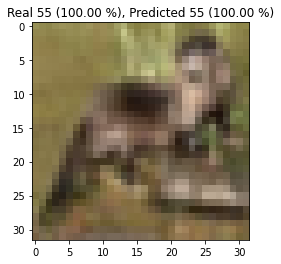

In [160]:
plt.imshow(x.cpu().permute(1, 2, 0))
plt.title('Real %i (%.2f %%), Predicted %i (%.2f %%)' % (t, torch.softmax(y, dim=1)[0, t].item() * 100, y.cpu().argmax(dim=1)[0].item(), torch.softmax(y, dim=1).max().item() * 100))
plt.show()

Check the labels [here](https://huggingface.co/datasets/cifar100)

Check one image from the test set

In [189]:
x, t = cifar_tst_dataset[5550]
x = x.cuda()
y = test_net(x.view(1, 3, 32, 32))

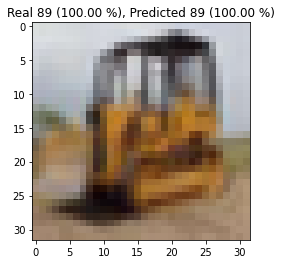

In [190]:
plt.imshow(x.cpu().permute(1, 2, 0))
plt.title('Real %i (%.2f %%), Predicted %i (%.2f %%)' % (t, torch.softmax(y, dim=1)[0, t].item() * 100, y.cpu().argmax(dim=1)[0].item(), torch.softmax(y, dim=1).max().item() * 100))
plt.show()